In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer

In [2]:
df=pd.read_excel('dataset_filledsupplier_currency_orderday.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24621 entries, 0 to 24620
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   청구서번호        24621 non-null  object 
 1   No.          24621 non-null  int64  
 2   Subject      24599 non-null  object 
 3   Machinery    24621 non-null  object 
 4   Assembly     24621 non-null  object 
 5   청구품목         24621 non-null  object 
 6   Unnamed: 6   0 non-null      float64
 7   Part No.1    24602 non-null  object 
 8   Part No.2    3592 non-null   object 
 9   청구량          24517 non-null  float64
 10  견적           24171 non-null  object 
 11  견적수량         24517 non-null  float64
 12  견적화폐         24621 non-null  object 
 13  견적단가         24621 non-null  float64
 14  발주번호         24621 non-null  object 
 15  발주처          24621 non-null  object 
 16  발주           24621 non-null  object 
 17  발주수량         24621 non-null  int64  
 18  발주금액         24621 non-null  float64
 19  D/T 

## 클리닝

In [4]:
missing_conditions = df[
    df['발주'].notnull() &  # 발주 일자는 비어있지 않음
    df['미입고 기간'].isnull() &  # 미입고 기간은 비어있음
    df['창고입고'].isnull() & # 창고 입고도 비어있음
    df['선박입고'].isnull()  # 선박 입고도 비어있음

]

print(f"발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: {len(missing_conditions)}개")
df = df.drop(missing_conditions.index)

print(f"삭제된 행의 개수: {len(missing_conditions)}개")
print(f"남은 데이터프레임의 크기: {df.shape}")

발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: 1699개
삭제된 행의 개수: 1699개
남은 데이터프레임의 크기: (22922, 32)


In [5]:
#미입고기간으로 처리.
missing_both = df[df['창고입고'].isnull() & df['미입고 기간'].notnull()]

print(f"창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : {len(missing_both)}개")

창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : 1620개


In [6]:
df = df[df['미입고 기간'].isnull()]

df['발주'] = pd.to_datetime(df['발주'], errors='coerce')
df['창고입고'] = pd.to_datetime(df['창고입고'], errors='coerce')

# 리드타임 계산
df['리드타임'] = (df['창고입고'] - df['발주']).dt.days
df['리드타임'] = df['리드타임'].apply(lambda x: 1 if x == 0 else x)

### 기존 리드타임 1< leadtime < 200

In [7]:
df = df[(df['리드타임'] > 1 ) & (df['리드타임'] < 150)]
df = df.dropna(subset=['창고입고'])

In [8]:
print(df[['발주', '창고입고']].head(), df['창고입고'].isnull().sum())

          발주       창고입고
0 2019-01-11 2019-05-03
1 2019-01-11 2019-04-18
2 2019-01-11 2019-05-03
5 2019-06-03 2019-06-15
6 2019-06-03 2019-06-15 0


### 날짜뽑기

> 연도는 숫자형으로 처리(새로운 연도에 대응)
> 나머지는 원핫인코딩

In [9]:
# 월(month), 요일(day of the week) 추출
df['month'] = df['창고입고'].dt.month
df['day_of_week'] = df['창고입고'].dt.dayofweek
df['year'] = df['창고입고'].dt.year

def get_season(date):
    month = date.month
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

df['season'] = df['창고입고'].apply(get_season)

df = pd.get_dummies(df, columns=['month', 'day_of_week', 'season'], drop_first=True)


In [10]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^\w\s\*/\-\+.,#&]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b(사용금지|사)\b', '', text, flags=re.IGNORECASE)
    text = text.strip()
    return text

def clean_supplier_name(name):
    name = name.lower()
    name = re.sub(r'coporation|coropration|coproration|corporration', 'corporation', name)
    name = re.sub(r'\(사용금지\)', '', name)
    name = re.sub(r'u\.s\.a', '_usa', name)
    name = re.sub(r'\.', '', name)
    suffixes = r'(corporation|corp|company|co|incorporated|inc|limited|ltd|상사|공사|엔지니어링|주식회사|주|gmbh|pte ltd|llc)'
    name = re.sub(suffixes, '', name, flags=re.IGNORECASE)
    name = re.sub(r'[^\w\s-]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name



In [11]:

text_columns = ['Machinery', 'Assembly', '청구품목']

for col in text_columns:
    df[col] = df[col].astype(str)
df['cleaned_machinery'] = df['Machinery'].apply(preprocess_text)
df['cleaned_assembly'] = df['Assembly'].apply(preprocess_text)
df['cleaned_item'] = df['청구품목'].apply(preprocess_text)
df['cleaned_supplier'] = df['발주처'].apply(clean_supplier_name)

> 단순 조합해서 평균낸게.. 악영향일까

In [12]:
# Machinery별 평균 리드타임 계산
machinery_avg_leadtime = df.groupby('cleaned_machinery')['리드타임'].mean().reset_index()
machinery_avg_leadtime.rename(columns={'리드타임': 'machinery_avg_leadtime'}, inplace=True)

# 데이터프레임에 평균 리드타임 추가
df = df.merge(machinery_avg_leadtime, on='cleaned_machinery', how='left')

In [15]:
# Machinery & Assembly & supplier 조합별 평균 리드타임 계산
df['machinery_assembly_supplier'] = df['cleaned_machinery'] + " & " + df['cleaned_assembly'] + " & " + df['cleaned_supplier']
machinery_assembly_supplier_avg_leadtime = df.groupby('machinery_assembly_supplier')['리드타임'].mean().reset_index()
machinery_assembly_supplier_avg_leadtime.rename(columns={'리드타임': 'machinery_assembly_supplier_avg_leadtime'}, inplace=True)

df = df.merge(machinery_assembly_supplier_avg_leadtime, on='machinery_assembly_supplier', how='left')

In [17]:
# Machinery & Assembly 조합별 평균 리드타임 계산
df['machinery_assembly'] = df['cleaned_machinery'] + " & " + df['cleaned_assembly']
assembly_machinery_avg_leadtime = df.groupby('machinery_assembly')['리드타임'].mean().reset_index()
assembly_machinery_avg_leadtime.rename(columns={'리드타임': 'machinery_assembly_avg_leadtime'}, inplace=True)

# 데이터프레임에 Machinery & Assembly 조합의 평균 리드타임 추가
df = df.merge(assembly_machinery_avg_leadtime, on='machinery_assembly', how='left')


In [24]:
# Assembly 평균 리드타임 계산
assembly_avg_leadtime = df.groupby('cleaned_assembly')['리드타임'].mean().reset_index()
assembly_avg_leadtime.rename(columns={'리드타임': 'assembly_avg_leadtime'}, inplace=True)

# 데이터프레임에 평균 리드타임 추가
df = df.merge(assembly_avg_leadtime, on='cleaned_assembly', how='left')

In [18]:
# 발주처별 평균 리드타임 계산 (cleaned_supplier 사용)
supplier_leadtime_avg = df.groupby('cleaned_supplier')['리드타임'].mean().reset_index()
supplier_leadtime_avg.rename(columns={'리드타임': 'supplier_avg_leadtime'}, inplace=True)

# 원본 데이터프레임에 발주처별 평균 리드타임 추가 (cleaned_supplier로 병합)
df = df.merge(supplier_leadtime_avg, on='cleaned_supplier', how='left')


In [19]:
# 발주처별 + Machinery 조합별 평균 리드타임 계산
supplier_machinery_leadtime = df.groupby(['cleaned_supplier', 'cleaned_machinery'])['리드타임'].mean().reset_index()
supplier_machinery_leadtime.rename(columns={'리드타임': 'supplier_machinery_avg_leadtime'}, inplace=True)

# 원본 데이터프레임에 병합
df = df.merge(supplier_machinery_leadtime, on=['cleaned_supplier', 'cleaned_machinery'], how='left')

In [25]:
df[['Machinery','Assembly','리드타임', '발주처', 'assembly_avg_leadtime', 'machinery_avg_leadtime', 'machinery_assembly_supplier_avg_leadtime','machinery_assembly_avg_leadtime', 'supplier_machinery_avg_leadtime']].tail(20)

,Machinery,Assembly,리드타임,발주처,assembly_avg_leadtime,machinery_avg_leadtime,machinery_assembly_supplier_avg_leadtime,machinery_assembly_avg_leadtime,supplier_machinery_avg_leadtime
17500,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,21,"PORT RELIEF ENGINEERING CO.,LTD.",25.647059,37.253131,15.395349,25.647059,21.185009
17501,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,21,"PORT RELIEF ENGINEERING CO.,LTD.",25.647059,37.253131,15.395349,25.647059,21.185009
17502,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,21,"PORT RELIEF ENGINEERING CO.,LTD.",25.647059,37.253131,15.395349,25.647059,21.185009
17503,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,21,"PORT RELIEF ENGINEERING CO.,LTD.",25.647059,37.253131,15.395349,25.647059,21.185009
17504,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,21,"PORT RELIEF ENGINEERING CO.,LTD.",25.647059,37.253131,15.395349,25.647059,21.185009
17505,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,21,"PORT RELIEF ENGINEERING CO.,LTD.",25.647059,37.253131,15.395349,25.647059,21.185009
17506,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,21,"PORT RELIEF ENGINEERING CO.,LTD.",25.647059,37.253131,15.395349,25.647059,21.185009
17507,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,61,"PORT RELIEF ENGINEERING CO.,LTD.",25.647059,37.253131,15.395349,25.647059,21.185009
17508,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,21,"PORT RELIEF ENGINEERING CO.,LTD.",25.647059,37.253131,15.395349,25.647059,21.185009
17509,6M NET BOAT ENGINE,FIG 39. COOLER(FRESH WATER),21,"PORT RELIEF ENGINEERING CO.,LTD.",24.722222,51.229584,12.200000,24.722222,23.058043


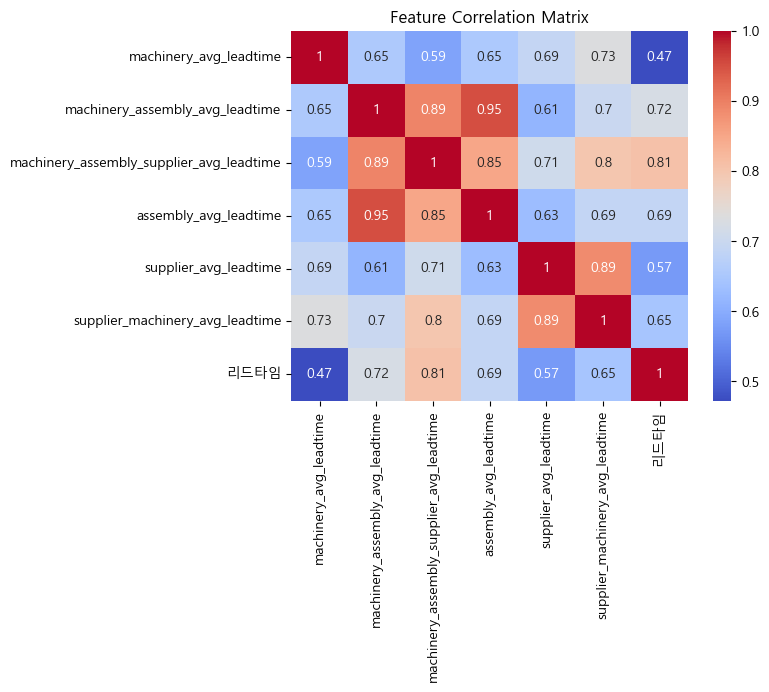

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# 피처 간 상관관계 계산 및 시각화
correlation_matrix = df[['machinery_avg_leadtime', 'machinery_assembly_avg_leadtime', 'machinery_assembly_supplier_avg_leadtime', 'assembly_avg_leadtime',
                         'supplier_avg_leadtime', 'supplier_machinery_avg_leadtime', '리드타임']].corr()
plt.rcParams['font.family']='Malgun Gothic'

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

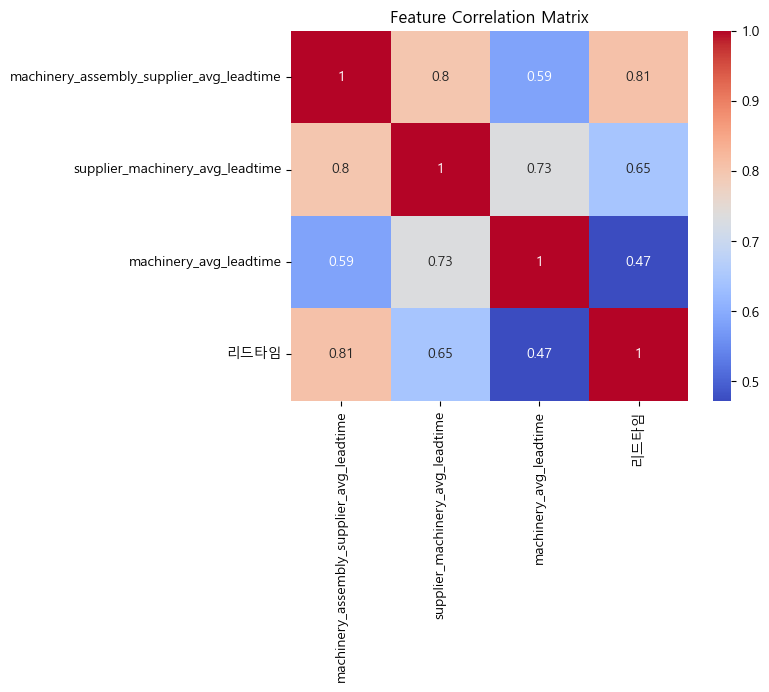

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# 살리고 싶은 피쳐
correlation_matrix = df[['machinery_assembly_supplier_avg_leadtime','supplier_machinery_avg_leadtime', 'machinery_avg_leadtime', '리드타임']].corr()
plt.rcParams['font.family']='Malgun Gothic'

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

### 리드타임 예측 (회귀)
1. 텍스트 칼럼 결합 word2vec
2. 수치형 데이터 Scaling
3. 범주형 데이터(견적화폐) onehotEncoding
4. 모델의 입력, 2.3데이터 결합 => 리드타임 예측

In [45]:
from scipy.stats import boxcox

X = df.drop(columns=['리드타임'])
y = df['리드타임'].values


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [46]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np

numerical_features = ['machinery_assembly_supplier_avg_leadtime','supplier_machinery_avg_leadtime', 'assembly_avg_leadtime']

scaler = MinMaxScaler()
X_train_numerical = scaler.fit_transform(X_train[numerical_features])
X_val_numerical = scaler.transform(X_val[numerical_features])
X_test_numerical = scaler.transform(X_test[numerical_features])



In [47]:

# 가중치 부여: 두 번째 칼럼인 'machinery_assembly_avg_leadtime'에 2배 가중치 적용
#X_train_numerical[:, 1] *= 2
#X_val_numerical[:, 1] *= 2
#X_test_numerical[:, 1] *= 2

# 결과 확인
# print(f"X_train_numerical with weight applied: {X_train_numerical[:5]}")

In [48]:
currency_ohe = OneHotEncoder(sparse_output=False)
currency_train_encoded = currency_ohe.fit_transform(X_train[['견적화폐']])
currency_val_encoded = currency_ohe.transform(X_val[['견적화폐']])
currency_test_encoded = currency_ohe.transform(X_test[['견적화폐']])


In [104]:
from gensim.models import Word2Vec

machinery_sentences_train = [text.split() for text in X_train['cleaned_machinery']]
assembly_sentences_train = [text.split() for text in X_train['cleaned_assembly']]

machinery_sentences_val = [text.split() for text in X_val['cleaned_machinery']]
assembly_sentences_val  = [text.split() for text in X_val['cleaned_assembly']]

machinery_sentences_test = [text.split() for text in X_test['cleaned_machinery']]
assembly_sentences_test = [text.split() for text in X_test['cleaned_assembly']]

word2vec_machinery = Word2Vec(sentences=machinery_sentences_train, vector_size=100, window=5, min_count=1, workers=4)
word2vec_assembly = Word2Vec(sentences=assembly_sentences_train, vector_size=100, window=5, min_count=1, workers=4)

def sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

machinery_vectors_train = np.array([sentence_vector(sentence.split(), word2vec_machinery) for sentence in X_train['cleaned_machinery']])
assembly_vectors_train = np.array([sentence_vector(sentence.split(), word2vec_assembly) for sentence in X_train['cleaned_assembly']])

machinery_vectors_val = np.array([sentence_vector(sentence.split(), word2vec_machinery) for sentence in X_val['cleaned_machinery']])
assembly_vectors_val = np.array([sentence_vector(sentence.split(), word2vec_assembly) for sentence in X_val['cleaned_assembly']])

machinery_vectors_test = np.array([sentence_vector(sentence.split(), word2vec_machinery) for sentence in X_test['cleaned_machinery']])
assembly_vectors_test = np.array([sentence_vector(sentence.split(), word2vec_assembly) for sentence in X_test['cleaned_assembly']])


In [86]:
supplier_sentences = [text.split() for text in df['cleaned_supplier']]

word2vec_supplier = Word2Vec(sentences=supplier_sentences, vector_size=100, window=5, min_count=1, workers=4)

supplier_vectors = np.array([sentence_vector(sentence, word2vec_supplier) for sentence in supplier_sentences])
print(f"Word2Vec Supplier Shape: {supplier_vectors.shape}")


Word2Vec Supplier Shape: (17520, 100)


In [87]:
#word2vec_supplier.save('word2vec_supplier.model')

In [88]:
#word2vec_machinery.save('word2vec_machinery.model')
#word2vec_assembly.save('word2vec_assembly.model')

In [105]:
X_train_month_features = X_train.filter(like='month_').values
X_train_day_of_week_features = X_train.filter(like='day_of_week_').values
X_train_season_features = X_train.filter(like='season_').values
year_train = X_train['year'].values.reshape(-1, 1)

X_test_month_features = X_test.filter(like='month_').values
X_test_day_of_week_features = X_test.filter(like='day_of_week_').values
X_test_season_features = X_test.filter(like='season_').values
year_test = X_test['year'].values.reshape(-1, 1)

X_val_month_features = X_val.filter(like='month_').values
X_val_day_of_week_features = X_val.filter(like='day_of_week_').values
X_val_season_features = X_val.filter(like='season_').values
year_val = X_val['year'].values.reshape(-1, 1)

In [106]:
X_train_combined = np.hstack((
    X_train_numerical,  # 스케일링된 수치형 피처들
    X_train_month_features,  # 월 One-Hot-Encoding 피처
    X_train_day_of_week_features,  # 요일 One-Hot-Encoding 피처
    year_train,  # 연도 숫자
    X_train_season_features,  # 계절 One-Hot-Encoding 피처
    currency_train_encoded,  # 견적화폐 One-Hot-Encoding 피처
    machinery_vectors_train,  # Word2Vec 벡터화된 machinery 피처
    assembly_vectors_train  # Word2Vec 벡터화된 assembly 피처
))
# 테스트 데이터 결합
X_val_combined = np.hstack((
    X_val_numerical,  # 스케일링된 수치형 피처들
    X_val_month_features,  # 월 One-Hot-Encoding 피처
    X_val_day_of_week_features,  # 요일 One-Hot-Encoding 피처
    year_val,  # 연도 숫자
    X_val_season_features,  # 계절 One-Hot-Encoding 피처
    currency_val_encoded,  # 견적화폐 One-Hot-Encoding 피처
    machinery_vectors_val,  # Word2Vec 벡터화된 machinery 피처
    assembly_vectors_val  # Word2Vec 벡터화된 assembly 피처
))

# 테스트 데이터 결합
X_test_combined = np.hstack((
    X_test_numerical,  # 스케일링된 수치형 피처들
    X_test_month_features,  # 월 One-Hot-Encoding 피처
    X_test_day_of_week_features,  # 요일 One-Hot-Encoding 피처
    year_test,  # 연도 숫자
    X_test_season_features,  # 계절 One-Hot-Encoding 피처
    currency_test_encoded,  # 견적화폐 One-Hot-Encoding 피처
    machinery_vectors_test,  # Word2Vec 벡터화된 machinery 피처
    assembly_vectors_test  # Word2Vec 벡터화된 assembly 피처
))

In [107]:
print(X_val_combined.shape)

(1314, 228)


In [108]:
#import pickle

#with open('MinMaxScaler.pkl', 'wb') as f:
#    pickle.dump(scaler, f)

### 데이터 분할


In [109]:
print(f"X_train shape: {X_train_combined.shape}")
print(f"X_train shape: {X_val_combined.shape}")
print(f"X_test shape: {X_test_combined.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (14892, 228)
X_train shape: (1314, 228)
X_test shape: (1314, 228)
y_train shape: (14892,)
y_test shape: (1314,)
y_test shape: (1314,)


In [110]:
import lightgbm as lgb
from lightgbm import callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


model_lgb = lgb.LGBMRegressor(
    objective='regression',
    metric='mae', 
    learning_rate=0.05,  
    num_leaves=30, 
    max_depth=8,  
    n_estimators=5000,  
    subsample=0.8,  
    colsample_bytree=0.7,  
    reg_alpha=0.1, 
    reg_lambda=0.1 
)

# 콜백 설정
callbacks = [
    callback.early_stopping(stopping_rounds=50),  
    callback.log_evaluation(period=1000)  
]

# 모델 학습
model_lgb.fit(
    X_train_combined, y_train,
    eval_set=[(X_val_combined, y_val)],  
    eval_metric='mae',
    callbacks=callbacks
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37743
[LightGBM] [Info] Number of data points in the train set: 14892, number of used features: 228
[LightGBM] [Info] Start training from score 58.985898
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's l1: 5.77261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=8,
              metric='mae', n_estimators=5000, num_leaves=30,
              objective='regression', reg_alpha=0.1, reg_lambda=0.1,
              subsample=0.8)

In [111]:
y_pred = model_lgb.predict(X_test_combined)
y_pred = np.maximum(0, y_pred)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

Mean Absolute Error (MAE): 4.315258451640762
Root Mean Squared Error (RMSE): 11.596447066323956
Mean Squared Error (MSE): 134.4775845620535
R^2 Score: 0.921461722674474


### 기존 1<리드타임<200 에 수치형 피쳐 m_a_s 합친거 사용하기 전 성능

> Mean Absolute Error (MAE): 5.402290372823216

> Root Mean Squared Error (RMSE): 15.153656625990125
 
> Mean Squared Error (MSE): 229.63330913841443
 
> R^2 Score: 0.9153701844128428

C:\Users\User\anaconda3\envs\ship\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


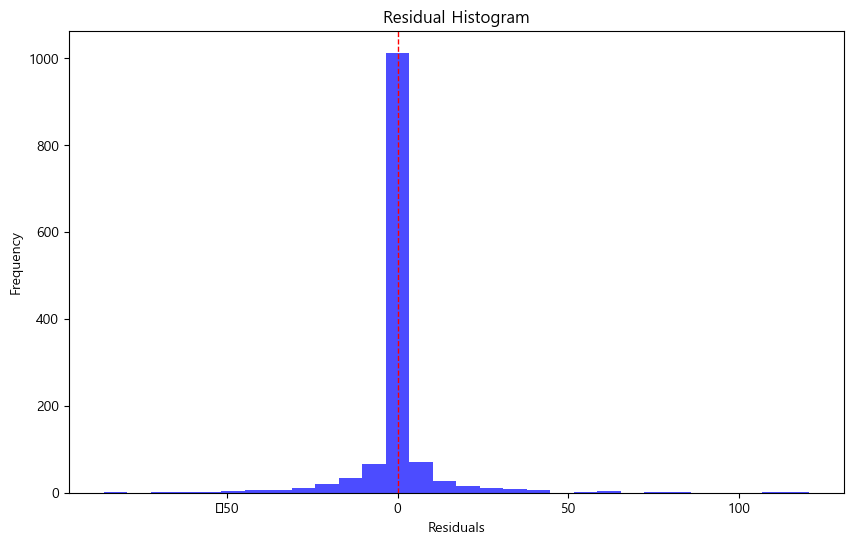

In [112]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Histogram')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)  
plt.show()

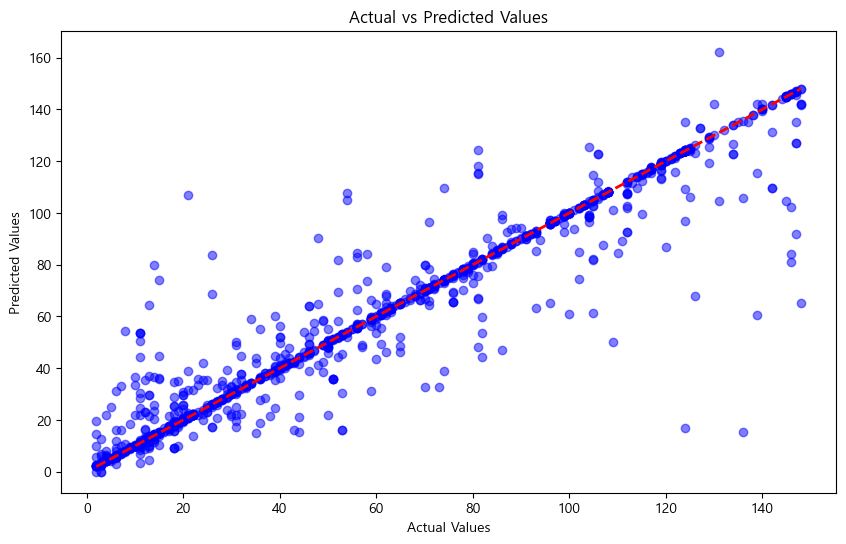

In [113]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # y=x 선
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [114]:

threshold = 50
residuals = y_test - y_pred
outliers = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Residual': residuals})
large_residuals = outliers[abs(outliers['Residual']) > threshold ] 
print(large_residuals)

      Actual   Predicted    Residual
37       126   68.023046   57.976954
306       13   64.579983  -51.579983
310       54  104.885546  -50.885546
339       21  107.046648  -86.046648
451       14   80.032351  -66.032351
465      147   91.854477   55.145523
823      124   16.976413  107.023587
875      109   49.967877   59.032123
911       54  107.810832  -53.810832
984      146   81.215243   64.784757
1080      15   74.102706  -59.102706
1103     146   84.075285   61.924715
1110     136   15.510582  120.489418
1160      26   83.703134  -57.703134
1161     139   60.459292   78.540708
1207     148   65.062159   82.937841


In [118]:
y_test_df = pd.DataFrame(y_test, columns=['리드타임'])

residuals = y_test_df.values.flatten() - y_pred  # 실제값 - 예측값
large_residuals = np.abs(residuals)  # 절대값으로 잔차 크기 계산
large_residuals_indices = np.where(large_residuals > threshold)[0]  # 특정 임계값보다 큰 잔차의 인덱스 추출
large_residuals_data = X_test.iloc[large_residuals_indices]
large_residuals_actual = y_test_df.iloc[large_residuals_indices]
large_residuals_predicted = y_pred[large_residuals_indices]

large_residuals_df = pd.DataFrame({
    'Actual': large_residuals_actual.values.flatten(),  
    'Predicted': large_residuals_predicted,
    'Residual': residuals[large_residuals_indices],
    'machinery_avg_leadtime': large_residuals_data['machinery_avg_leadtime'].values,
    'machinery_assembly_avg_leadtime': large_residuals_data['machinery_assembly_avg_leadtime'].values,
    'supplier_machinery_avg_leadtime': large_residuals_data['supplier_machinery_avg_leadtime'].values,
    'machinery_assembly_supplier_avg_leadtime': large_residuals_data['machinery_assembly_supplier_avg_leadtime'].values,
    'machinery' : large_residuals_data['Machinery'].values,
    'assembly' : large_residuals_data['Assembly'].values,
    'supplier' : large_residuals_data['발주처'].values
})

print(large_residuals_df.head(30))

    Actual   Predicted    Residual  machinery_avg_leadtime  \
0      126   68.023046   57.976954               56.875088   
1       13   64.579983  -51.579983               42.222973   
2       54  104.885546  -50.885546               80.628627   
3       21  107.046648  -86.046648               75.056680   
4       14   80.032351  -66.032351               56.875088   
5      147   91.854477   55.145523               56.875088   
6      124   16.976413  107.023587               75.978510   
7      109   49.967877   59.032123               73.403509   
8       54  107.810832  -53.810832               80.628627   
9      146   81.215243   64.784757               75.978510   
10      15   74.102706  -59.102706               46.333333   
11     146   84.075285   61.924715               75.978510   
12     136   15.510582  120.489418               56.875088   
13      26   83.703134  -57.703134               80.628627   
14     139   60.459292   78.540708               56.875088   
15     1